#LB 3.2585

In [21]:
import pandas as pd

In [22]:
import numpy as np
import random
import os
import gc
from tqdm import tqdm

In [23]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(113) # Seed 고정

In [48]:
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv( 'test.csv', encoding='utf-8')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0, encoding='utf-8')

In [28]:
import re 
def preprocessing_data(df):
    
    # 데이터 정리
    df['Book-Title'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Book-Title']]
    df['Main_Title'] = [i.split('  ')[0] for i in df['Book-Title']]
    df['Sub_Title'] = [''.join(i.split('  ')[1:]) for i in df['Book-Title']]
    df['Sub_Title'] = np.where(df['Sub_Title'] == '', 'No_SUB', df['Sub_Title'])
    
    df['Location'] = [re.sub(r'[^0-9a-zA-Z:,]',  ' ',str(i)) for i in df['Location']]
    
    df['City'] = [(i.split(',')[0]).lstrip().lower() for i in df['Location']]
    df['State'] = [(i.split(',')[1]).lstrip().lower() for i in df['Location']]
    df['Country'] = [(i.split(',')[2]).lstrip().lower() for i in df['Location']]

    # preprocessing Location
    # NaN, N/A, etc.. Change 'unknown'
    # Only using Train Data	#
    
    # 최빈값을 사용하기 위해 새로운 데이터 프레임 생성(pd.Series.mode를 이용하면 같은 count수의 값을 list로 묶어서 정확하지 않음)
    new_state = train_lb.groupby(['City'])['State'].value_counts().to_frame().rename(columns = {'State' : 'count'}).reset_index()
    new_state = new_state[(~new_state['City'].isna())&(~new_state['State'].isna())&(new_state['count']!=1)]
    new_state = new_state.sort_values(by=['City', 'count'], ascending=[True, False]).drop_duplicates(subset='City', keep='first')
    new_state = new_state.rename(columns = {'State' : 'N_State'}) 
    new_state = new_state.drop(columns = ['count'])
    
    new_country = train_lb.groupby(['State'])['Country'].value_counts().to_frame().rename(columns = {'Country' : 'count'}).reset_index()
    new_country = new_country[(~new_country['State'].isna())&(~new_country['Country'].isna())&(new_country['count']!=1)]
    new_country = new_country.sort_values(by=['State', 'count'], ascending=[True, False]).drop_duplicates(subset='State', keep='first')
    new_country = new_country.rename(columns = {'Country' : 'N_Country'}) 
    new_country = new_country.drop(columns = ['count'])
    
    df = pd.merge(df, new_country, on = 'State', how = 'left')
    df = pd.merge(df, new_state, on = 'City', how = 'left')
    
    df['Country'] = np.where((df['Country'] == '')|(df['Country'].astype(str) == 'nan'), df['N_Country'], df['Country'])
    df['State'] = np.where((df['State'] == '')|(df['State'].astype(str) == 'nan'), df['N_State'], df['State'])
    
    # 채워지지 않은 값은 Unknown 처리
    df[['Country', 'State', 'City']] = df[['Country', 'State', 'City']].fillna(value= 'Unknown')
    df = df.drop(columns = ['N_Country', 'N_State'])
    
    return df
    

In [39]:
def feature_engineering(df):
    labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
    bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
    
    # Age 이상치 처리
    df['Age'] = df['Age'].apply(lambda x: 3 if x<3 else x)
    df['Age'] = df['Age'].apply(lambda x: 100 if x>100 else x)

    #df.loc[(df['Age'] > 90) | (df['Age'] < 3), 'Age'] = np.nan
    
    # 평균값으로 대체
    #df['Age'] = df['Age'].fillna(df['Age'].mean())
    #df['Age'] = df['Age'].astype(np.int32)

    
    df['Age_gb'] = pd.cut(df.Age, bins, labels = labels,include_lowest = True)
    
    # 출판년도 그룹화
    # 만약 출판연도가 null이 있다면 정보없음(-1)로 채움
    #df['Year-Of-Publication'] = df['Year-Of-Publication'].fillna(-1)
    #labels = ['Unknown', '-1900', '1900-1950', '1950-1960', '1960-1970', '1970-1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020', '2020-']
    #bins = [-1, 0, 1900, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 3000]
    #df['Pub_gb'] = pd.cut(df['Year-Of-Publication'], bins, labels = labels,include_lowest = True)    
    
    return df


In [41]:
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

FEATURE = ['User-ID','Book-Title', 'Main_Title','Sub_Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Pub_gb']#, 'Language'] ', 

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

train_lb = preprocessing_data(train_lb)
test_lb = preprocessing_data(test_lb)

train_lb = feature_engineering(train_lb)
test_lb = feature_engineering(test_lb)

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))


In [42]:
X_train = train_lb.drop(columns = ['ID' , 'Book-Title', 'Book-Rating'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID','Book-Title'])

<Figure size 700x700 with 0 Axes>

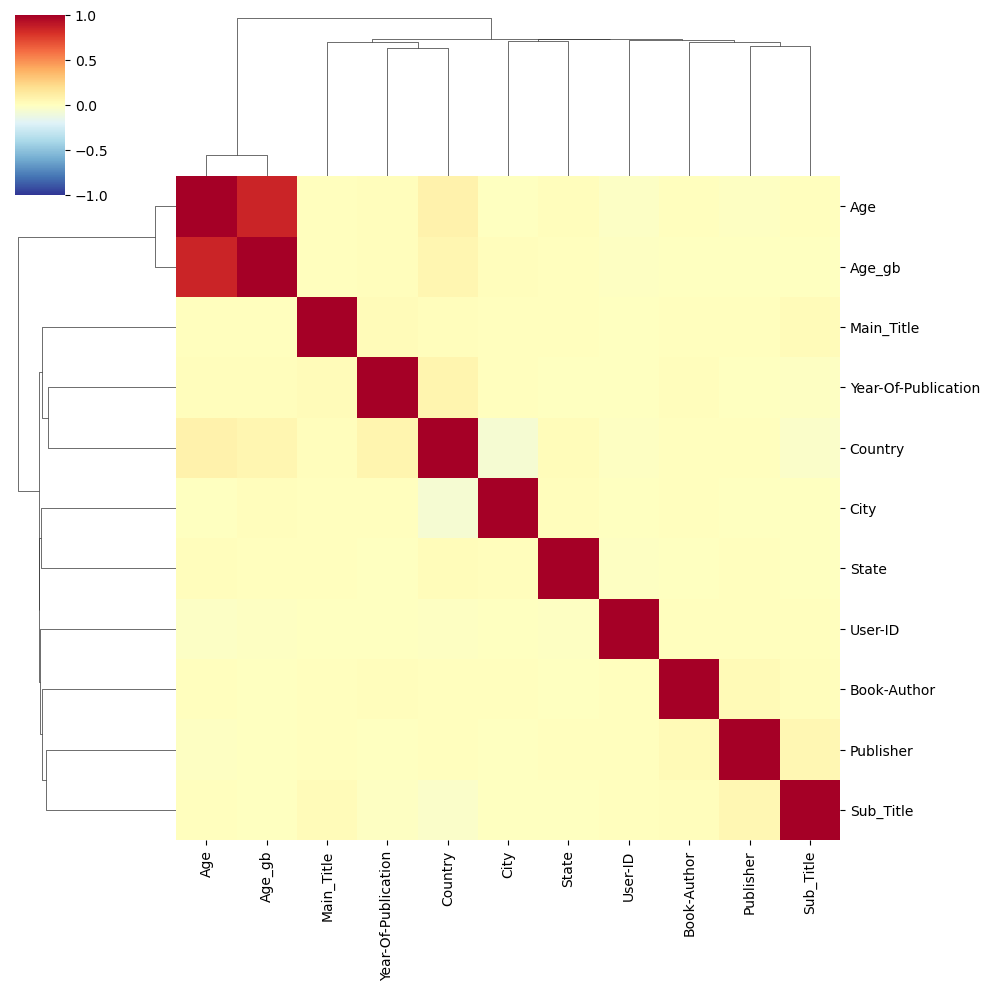

In [43]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize = (7, 7))
clustermap = sns.clustermap(X_train.corr(), cmap = 'RdYlBu_r',vmin = -1, vmax = 1, annot = False)

In [44]:
from catboost import CatBoostRegressor, Pool
model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )

0it [00:00, ?it/s]


Fold  0
0:	learn: 3.8400455	test: 3.8396220	best: 3.8396220 (0)	total: 102ms	remaining: 14m 49s
500:	learn: 3.3156602	test: 3.2877478	best: 3.2877478 (500)	total: 58.3s	remaining: 15m 52s
1000:	learn: 3.2722902	test: 3.2682831	best: 3.2682831 (1000)	total: 1m 56s	remaining: 14m 52s
1500:	learn: 3.2419177	test: 3.2605200	best: 3.2605173 (1498)	total: 2m 55s	remaining: 14m 2s
2000:	learn: 3.2153468	test: 3.2563736	best: 3.2563736 (2000)	total: 3m 56s	remaining: 13m 11s
2500:	learn: 3.1906994	test: 3.2532971	best: 3.2532971 (2500)	total: 4m 57s	remaining: 12m 16s
3000:	learn: 3.1671783	test: 3.2510729	best: 3.2510729 (3000)	total: 5m 57s	remaining: 11m 18s
3500:	learn: 3.1449142	test: 3.2496621	best: 3.2496538 (3495)	total: 6m 59s	remaining: 10m 22s
4000:	learn: 3.1234293	test: 3.2484907	best: 3.2484907 (4000)	total: 8m 2s	remaining: 9m 26s
4500:	learn: 3.1019616	test: 3.2479189	best: 3.2479039 (4493)	total: 9m 5s	remaining: 8m 28s
5000:	learn: 3.0813198	test: 3.2473517	best: 3.2473321 (

1it [10:46, 646.08s/it]


Fold  1
0:	learn: 3.8400107	test: 3.8396541	best: 3.8396541 (0)	total: 106ms	remaining: 15m 17s
500:	learn: 3.3167759	test: 3.2781392	best: 3.2781392 (500)	total: 57.7s	remaining: 15m 43s
1000:	learn: 3.2731914	test: 3.2576954	best: 3.2576954 (1000)	total: 1m 56s	remaining: 14m 52s
1500:	learn: 3.2419328	test: 3.2493103	best: 3.2493103 (1500)	total: 2m 54s	remaining: 13m 54s
2000:	learn: 3.2153970	test: 3.2443467	best: 3.2443459 (1999)	total: 3m 54s	remaining: 13m 2s
2500:	learn: 3.1908845	test: 3.2409778	best: 3.2409778 (2500)	total: 4m 54s	remaining: 12m 10s
3000:	learn: 3.1673706	test: 3.2385538	best: 3.2385538 (3000)	total: 5m 57s	remaining: 11m 18s
3500:	learn: 3.1451193	test: 3.2367139	best: 3.2367118 (3499)	total: 6m 58s	remaining: 10m 20s
4000:	learn: 3.1232713	test: 3.2351259	best: 3.2351211 (3998)	total: 8m	remaining: 9m 23s
4500:	learn: 3.1028104	test: 3.2341184	best: 3.2341183 (4499)	total: 9m 2s	remaining: 8m 25s
5000:	learn: 3.0822424	test: 3.2332674	best: 3.2332553 (499

2it [23:31, 716.22s/it]


Fold  2
0:	learn: 3.8399948	test: 3.8394253	best: 3.8394253 (0)	total: 106ms	remaining: 15m 20s
500:	learn: 3.3178951	test: 3.2696401	best: 3.2696401 (500)	total: 59.2s	remaining: 16m 8s
1000:	learn: 3.2744872	test: 3.2484121	best: 3.2484121 (1000)	total: 1m 58s	remaining: 15m 10s
1500:	learn: 3.2431011	test: 3.2400227	best: 3.2400227 (1500)	total: 3m	remaining: 14m 23s
2000:	learn: 3.2152136	test: 3.2354570	best: 3.2354570 (2000)	total: 4m 3s	remaining: 13m 32s
2500:	learn: 3.1901922	test: 3.2323135	best: 3.2323116 (2499)	total: 5m 5s	remaining: 12m 35s
3000:	learn: 3.1666731	test: 3.2305855	best: 3.2305729 (2995)	total: 6m 6s	remaining: 11m 36s
3500:	learn: 3.1442477	test: 3.2288647	best: 3.2288647 (3500)	total: 7m 7s	remaining: 10m 34s
4000:	learn: 3.1225343	test: 3.2276848	best: 3.2276793 (3999)	total: 8m 10s	remaining: 9m 35s
4500:	learn: 3.1015562	test: 3.2265796	best: 3.2265767 (4498)	total: 9m 13s	remaining: 8m 36s
5000:	learn: 3.0816355	test: 3.2257648	best: 3.2257644 (4999)	

3it [36:23, 741.63s/it]


Fold  3
0:	learn: 3.8400147	test: 3.8395236	best: 3.8395236 (0)	total: 94.4ms	remaining: 13m 40s
500:	learn: 3.3162897	test: 3.2754777	best: 3.2754777 (500)	total: 1m 4s	remaining: 17m 39s
1000:	learn: 3.2733248	test: 3.2570647	best: 3.2570647 (1000)	total: 2m 3s	remaining: 15m 52s
1500:	learn: 3.2421182	test: 3.2496687	best: 3.2496687 (1500)	total: 3m 1s	remaining: 14m 31s
2000:	learn: 3.2144150	test: 3.2457734	best: 3.2457734 (2000)	total: 4m 3s	remaining: 13m 34s
2500:	learn: 3.1892646	test: 3.2432515	best: 3.2432475 (2499)	total: 5m 3s	remaining: 12m 32s
3000:	learn: 3.1655299	test: 3.2413325	best: 3.2413285 (2999)	total: 5m 59s	remaining: 11m 21s
3500:	learn: 3.1427174	test: 3.2403024	best: 3.2403024 (3500)	total: 6m 54s	remaining: 10m 14s
4000:	learn: 3.1206314	test: 3.2391609	best: 3.2391593 (3998)	total: 7m 48s	remaining: 9m 9s
4500:	learn: 3.0999258	test: 3.2382277	best: 3.2382181 (4498)	total: 8m 43s	remaining: 8m 8s
5000:	learn: 3.0790769	test: 3.2378827	best: 3.2378676 (49

4it [46:56, 698.79s/it]


Fold  4
0:	learn: 3.8400423	test: 3.8396085	best: 3.8396085 (0)	total: 87.1ms	remaining: 12m 36s
500:	learn: 3.3156757	test: 3.2848193	best: 3.2848193 (500)	total: 50.3s	remaining: 13m 43s
1000:	learn: 3.2725003	test: 3.2652791	best: 3.2652791 (1000)	total: 1m 42s	remaining: 13m 10s
1500:	learn: 3.2405956	test: 3.2573062	best: 3.2573062 (1500)	total: 2m 35s	remaining: 12m 25s
2000:	learn: 3.2131898	test: 3.2529392	best: 3.2529392 (2000)	total: 3m 30s	remaining: 11m 43s
2500:	learn: 3.1880639	test: 3.2501485	best: 3.2501485 (2500)	total: 4m 24s	remaining: 10m 55s
3000:	learn: 3.1644238	test: 3.2480841	best: 3.2480841 (3000)	total: 5m 17s	remaining: 10m 1s
3500:	learn: 3.1422823	test: 3.2465976	best: 3.2465976 (3500)	total: 6m 12s	remaining: 9m 12s
4000:	learn: 3.1205476	test: 3.2453479	best: 3.2453479 (4000)	total: 7m 5s	remaining: 8m 18s
4500:	learn: 3.0995030	test: 3.2446355	best: 3.2446147 (4484)	total: 7m 59s	remaining: 7m 26s
5000:	learn: 3.0788367	test: 3.2437931	best: 3.2437930 

5it [57:53, 683.67s/it]


Fold  5
0:	learn: 3.8400386	test: 3.8394120	best: 3.8394120 (0)	total: 83.8ms	remaining: 12m 8s
500:	learn: 3.3171237	test: 3.2720557	best: 3.2720557 (500)	total: 49.3s	remaining: 13m 26s
1000:	learn: 3.2737060	test: 3.2527364	best: 3.2527364 (1000)	total: 1m 39s	remaining: 12m 47s
1500:	learn: 3.2426048	test: 3.2449535	best: 3.2449535 (1500)	total: 2m 30s	remaining: 12m 3s
2000:	learn: 3.2157300	test: 3.2402534	best: 3.2402534 (2000)	total: 3m 24s	remaining: 11m 24s
2500:	learn: 3.1906576	test: 3.2366199	best: 3.2366199 (2500)	total: 4m 17s	remaining: 10m 37s
3000:	learn: 3.1671417	test: 3.2344392	best: 3.2344295 (2999)	total: 5m 10s	remaining: 9m 48s
3500:	learn: 3.1450867	test: 3.2329154	best: 3.2328939 (3490)	total: 6m 3s	remaining: 8m 59s
4000:	learn: 3.1229535	test: 3.2315166	best: 3.2315166 (4000)	total: 6m 55s	remaining: 8m 7s
4500:	learn: 3.1021000	test: 3.2305973	best: 3.2305942 (4498)	total: 7m 49s	remaining: 7m 17s
5000:	learn: 3.0813371	test: 3.2295837	best: 3.2295837 (50

6it [1:09:21, 685.19s/it]


Fold  6
0:	learn: 3.8400935	test: 3.8395428	best: 3.8395428 (0)	total: 82.4ms	remaining: 11m 55s
500:	learn: 3.3162926	test: 3.2800759	best: 3.2800759 (500)	total: 52.6s	remaining: 14m 19s
1000:	learn: 3.2723424	test: 3.2603501	best: 3.2603501 (1000)	total: 1m 46s	remaining: 13m 38s
1500:	learn: 3.2409022	test: 3.2527449	best: 3.2527449 (1500)	total: 2m 38s	remaining: 12m 39s
2000:	learn: 3.2134359	test: 3.2482602	best: 3.2482597 (1998)	total: 3m 33s	remaining: 11m 52s
2500:	learn: 3.1885185	test: 3.2452248	best: 3.2452096 (2492)	total: 4m 28s	remaining: 11m 5s
3000:	learn: 3.1644932	test: 3.2426900	best: 3.2426900 (3000)	total: 5m 22s	remaining: 10m 11s
3500:	learn: 3.1421230	test: 3.2408053	best: 3.2408043 (3499)	total: 6m 16s	remaining: 9m 17s
4000:	learn: 3.1207961	test: 3.2396186	best: 3.2395927 (3998)	total: 7m 10s	remaining: 8m 25s
4500:	learn: 3.0997530	test: 3.2387159	best: 3.2386836 (4483)	total: 8m 6s	remaining: 7m 32s
5000:	learn: 3.0795885	test: 3.2377221	best: 3.2377147 

7it [1:22:07, 711.58s/it]


Fold  7
0:	learn: 3.8399983	test: 3.8396263	best: 3.8396263 (0)	total: 87.6ms	remaining: 12m 41s
500:	learn: 3.3165339	test: 3.2871881	best: 3.2871881 (500)	total: 50.1s	remaining: 13m 38s
1000:	learn: 3.2738237	test: 3.2674094	best: 3.2674094 (1000)	total: 1m 39s	remaining: 12m 43s
1500:	learn: 3.2431827	test: 3.2587678	best: 3.2587678 (1500)	total: 2m 29s	remaining: 11m 55s
2000:	learn: 3.2156353	test: 3.2538929	best: 3.2538929 (2000)	total: 3m 19s	remaining: 11m 8s
2500:	learn: 3.1911838	test: 3.2503366	best: 3.2503366 (2500)	total: 4m 10s	remaining: 10m 19s
3000:	learn: 3.1670676	test: 3.2477416	best: 3.2477268 (2999)	total: 5m 2s	remaining: 9m 33s
3500:	learn: 3.1447071	test: 3.2461053	best: 3.2461053 (3500)	total: 5m 53s	remaining: 8m 44s
4000:	learn: 3.1228051	test: 3.2446382	best: 3.2446218 (3997)	total: 6m 44s	remaining: 7m 54s
4500:	learn: 3.1017485	test: 3.2434456	best: 3.2434450 (4499)	total: 7m 35s	remaining: 7m 4s
5000:	learn: 3.0812276	test: 3.2423132	best: 3.2422909 (4

8it [1:35:01, 731.54s/it]


Fold  8
0:	learn: 3.8400895	test: 3.8395717	best: 3.8395717 (0)	total: 81.2ms	remaining: 11m 45s
500:	learn: 3.3182809	test: 3.2595017	best: 3.2595017 (500)	total: 48.8s	remaining: 13m 17s
1000:	learn: 3.2755399	test: 3.2394101	best: 3.2394101 (1000)	total: 1m 38s	remaining: 12m 36s
1500:	learn: 3.2442156	test: 3.2320167	best: 3.2320167 (1500)	total: 2m 28s	remaining: 11m 51s
2000:	learn: 3.2165225	test: 3.2276602	best: 3.2276602 (2000)	total: 3m 19s	remaining: 11m 6s
2500:	learn: 3.1917533	test: 3.2247232	best: 3.2247232 (2500)	total: 4m 10s	remaining: 10m 19s
3000:	learn: 3.1681148	test: 3.2230944	best: 3.2230944 (3000)	total: 5m 1s	remaining: 9m 31s
3500:	learn: 3.1454901	test: 3.2214830	best: 3.2214788 (3495)	total: 5m 52s	remaining: 8m 42s
4000:	learn: 3.1239051	test: 3.2203603	best: 3.2203531 (3999)	total: 6m 43s	remaining: 7m 53s
4500:	learn: 3.1035511	test: 3.2197250	best: 3.2197201 (4499)	total: 7m 34s	remaining: 7m 3s
5000:	learn: 3.0837147	test: 3.2189006	best: 3.2188895 (4

9it [1:44:21, 677.75s/it]


Fold  9
0:	learn: 3.8400052	test: 3.8395822	best: 3.8395822 (0)	total: 71.9ms	remaining: 10m 25s
500:	learn: 3.3156649	test: 3.2877624	best: 3.2877624 (500)	total: 48.8s	remaining: 13m 17s
1000:	learn: 3.2717586	test: 3.2683107	best: 3.2683107 (1000)	total: 1m 38s	remaining: 12m 40s
1500:	learn: 3.2407889	test: 3.2605974	best: 3.2605974 (1500)	total: 2m 28s	remaining: 11m 53s
2000:	learn: 3.2144896	test: 3.2558495	best: 3.2558495 (2000)	total: 3m 19s	remaining: 11m 7s
2500:	learn: 3.1892148	test: 3.2528906	best: 3.2528891 (2499)	total: 4m 10s	remaining: 10m 20s
3000:	learn: 3.1652975	test: 3.2503317	best: 3.2503317 (3000)	total: 5m 1s	remaining: 9m 31s
3500:	learn: 3.1432146	test: 3.2488184	best: 3.2488184 (3500)	total: 5m 52s	remaining: 8m 42s
4000:	learn: 3.1213213	test: 3.2479309	best: 3.2479255 (3986)	total: 6m 43s	remaining: 7m 53s
4500:	learn: 3.1007577	test: 3.2470450	best: 3.2470304 (4481)	total: 7m 34s	remaining: 7m 3s
5000:	learn: 3.0796123	test: 3.2465279	best: 3.2465246 (4

10it [1:56:03, 685.51s/it]


Fold  10
0:	learn: 3.8400161	test: 3.8395923	best: 3.8395923 (0)	total: 81.3ms	remaining: 11m 46s
500:	learn: 3.3173229	test: 3.2766761	best: 3.2766761 (500)	total: 48.8s	remaining: 13m 18s
1000:	learn: 3.2729961	test: 3.2566181	best: 3.2566181 (1000)	total: 1m 38s	remaining: 12m 36s
1500:	learn: 3.2420999	test: 3.2488188	best: 3.2488188 (1500)	total: 2m 28s	remaining: 11m 51s
2000:	learn: 3.2153545	test: 3.2442120	best: 3.2442120 (2000)	total: 3m 19s	remaining: 11m 5s
2500:	learn: 3.1901756	test: 3.2413233	best: 3.2413233 (2500)	total: 4m 10s	remaining: 10m 19s
3000:	learn: 3.1672631	test: 3.2391737	best: 3.2391737 (3000)	total: 5m 3s	remaining: 9m 35s
3500:	learn: 3.1448854	test: 3.2377990	best: 3.2377990 (3500)	total: 6m 3s	remaining: 8m 58s
4000:	learn: 3.1237399	test: 3.2369204	best: 3.2369121 (3996)	total: 7m 6s	remaining: 8m 20s
4500:	learn: 3.1032915	test: 3.2361449	best: 3.2361446 (4498)	total: 8m 7s	remaining: 7m 34s
5000:	learn: 3.0827486	test: 3.2355295	best: 3.2355115 (49

11it [2:05:24, 647.38s/it]


Fold  11
0:	learn: 3.8400003	test: 3.8395884	best: 3.8395884 (0)	total: 90.3ms	remaining: 13m 5s
500:	learn: 3.3166772	test: 3.2890985	best: 3.2890985 (500)	total: 53.1s	remaining: 14m 28s
1000:	learn: 3.2736833	test: 3.2685190	best: 3.2685167 (999)	total: 1m 48s	remaining: 13m 56s
1500:	learn: 3.2426953	test: 3.2607514	best: 3.2607514 (1500)	total: 2m 45s	remaining: 13m 10s
2000:	learn: 3.2161160	test: 3.2562792	best: 3.2562792 (2000)	total: 3m 42s	remaining: 12m 25s
2500:	learn: 3.1914652	test: 3.2531632	best: 3.2531632 (2500)	total: 4m 40s	remaining: 11m 35s
3000:	learn: 3.1682562	test: 3.2509977	best: 3.2509977 (3000)	total: 5m 37s	remaining: 10m 40s
3500:	learn: 3.1453627	test: 3.2493167	best: 3.2493167 (3500)	total: 6m 34s	remaining: 9m 45s
4000:	learn: 3.1234778	test: 3.2484824	best: 3.2484824 (4000)	total: 7m 32s	remaining: 8m 50s
4500:	learn: 3.1022243	test: 3.2474510	best: 3.2474510 (4500)	total: 8m 31s	remaining: 7m 56s
5000:	learn: 3.0817566	test: 3.2467261	best: 3.2467191

12it [2:15:44, 639.01s/it]


Fold  12
0:	learn: 3.8400236	test: 3.8394974	best: 3.8394974 (0)	total: 89.2ms	remaining: 12m 55s
500:	learn: 3.3169717	test: 3.2743714	best: 3.2743714 (500)	total: 54s	remaining: 14m 43s
1000:	learn: 3.2744714	test: 3.2537786	best: 3.2537786 (1000)	total: 1m 51s	remaining: 14m 13s
1500:	learn: 3.2436384	test: 3.2455191	best: 3.2455191 (1500)	total: 2m 50s	remaining: 13m 37s
2000:	learn: 3.2163040	test: 3.2408782	best: 3.2408782 (2000)	total: 3m 51s	remaining: 12m 54s
2500:	learn: 3.1909438	test: 3.2377656	best: 3.2377656 (2500)	total: 4m 51s	remaining: 12m 2s
3000:	learn: 3.1675319	test: 3.2354563	best: 3.2354563 (3000)	total: 5m 50s	remaining: 11m 4s
3500:	learn: 3.1451848	test: 3.2340430	best: 3.2340419 (3496)	total: 6m 47s	remaining: 10m 4s
4000:	learn: 3.1235495	test: 3.2329353	best: 3.2329324 (3998)	total: 7m 44s	remaining: 9m 5s
4500:	learn: 3.1026421	test: 3.2319417	best: 3.2319417 (4500)	total: 8m 42s	remaining: 8m 6s
5000:	learn: 3.0827046	test: 3.2313196	best: 3.2313173 (49

13it [2:28:21, 674.75s/it]


Fold  13
0:	learn: 3.8400230	test: 3.8395953	best: 3.8395953 (0)	total: 79.3ms	remaining: 11m 29s
500:	learn: 3.3166607	test: 3.2836215	best: 3.2836215 (500)	total: 55s	remaining: 14m 59s
1000:	learn: 3.2726825	test: 3.2651595	best: 3.2651595 (1000)	total: 1m 50s	remaining: 14m 11s
1500:	learn: 3.2412360	test: 3.2577193	best: 3.2577184 (1499)	total: 2m 49s	remaining: 13m 30s
2000:	learn: 3.2134226	test: 3.2537302	best: 3.2537302 (2000)	total: 3m 46s	remaining: 12m 39s
2500:	learn: 3.1881131	test: 3.2510337	best: 3.2510337 (2500)	total: 4m 44s	remaining: 11m 45s
3000:	learn: 3.1640574	test: 3.2490216	best: 3.2490216 (3000)	total: 5m 42s	remaining: 10m 50s
3500:	learn: 3.1416809	test: 3.2474872	best: 3.2474872 (3500)	total: 6m 41s	remaining: 9m 56s
4000:	learn: 3.1200467	test: 3.2464450	best: 3.2464158 (3984)	total: 7m 38s	remaining: 8m 58s
4500:	learn: 3.0992098	test: 3.2452541	best: 3.2452541 (4500)	total: 8m 37s	remaining: 8m 2s
5000:	learn: 3.0788822	test: 3.2443011	best: 3.2442911 

14it [2:40:38, 693.61s/it]


Fold  14
0:	learn: 3.8400329	test: 3.8395336	best: 3.8395336 (0)	total: 73.9ms	remaining: 10m 42s
500:	learn: 3.3167637	test: 3.2724337	best: 3.2724337 (500)	total: 55.7s	remaining: 15m 11s
1000:	learn: 3.2734053	test: 3.2520070	best: 3.2520070 (1000)	total: 1m 52s	remaining: 14m 27s
1500:	learn: 3.2418915	test: 3.2435609	best: 3.2435609 (1500)	total: 2m 58s	remaining: 14m 15s
2000:	learn: 3.2147061	test: 3.2390948	best: 3.2390948 (2000)	total: 4m 3s	remaining: 13m 33s
2500:	learn: 3.1906560	test: 3.2359590	best: 3.2359553 (2499)	total: 5m 24s	remaining: 13m 22s
3000:	learn: 3.1671092	test: 3.2335183	best: 3.2335167 (2999)	total: 6m 23s	remaining: 12m 6s
3500:	learn: 3.1451005	test: 3.2318687	best: 3.2318687 (3500)	total: 7m 29s	remaining: 11m 6s
4000:	learn: 3.1232897	test: 3.2305888	best: 3.2305888 (4000)	total: 8m 42s	remaining: 10m 13s
4500:	learn: 3.1021376	test: 3.2296133	best: 3.2296111 (4496)	total: 10m 16s	remaining: 9m 34s
5000:	learn: 3.0812952	test: 3.2288890	best: 3.22887

15it [2:54:14, 730.51s/it]


Fold  15
0:	learn: 3.8400473	test: 3.8393711	best: 3.8393711 (0)	total: 81.6ms	remaining: 11m 49s
500:	learn: 3.3176131	test: 3.2671685	best: 3.2671685 (500)	total: 48.5s	remaining: 13m 13s
1000:	learn: 3.2745637	test: 3.2471911	best: 3.2471911 (1000)	total: 1m 37s	remaining: 12m 30s
1500:	learn: 3.2436601	test: 3.2393427	best: 3.2393427 (1500)	total: 2m 27s	remaining: 11m 46s
2000:	learn: 3.2167243	test: 3.2347253	best: 3.2347246 (1997)	total: 3m 17s	remaining: 11m 1s
2500:	learn: 3.1909038	test: 3.2313838	best: 3.2313838 (2500)	total: 4m 8s	remaining: 10m 15s
3000:	learn: 3.1665444	test: 3.2295417	best: 3.2295417 (3000)	total: 4m 58s	remaining: 9m 27s
3500:	learn: 3.1436019	test: 3.2278237	best: 3.2278206 (3499)	total: 5m 49s	remaining: 8m 38s
4000:	learn: 3.1217436	test: 3.2266310	best: 3.2266124 (3996)	total: 6m 41s	remaining: 7m 50s
4500:	learn: 3.1005431	test: 3.2256023	best: 3.2255970 (4496)	total: 7m 31s	remaining: 7m 1s
5000:	learn: 3.0794916	test: 3.2248309	best: 3.2248138 (

16it [3:04:03, 687.74s/it]


Fold  16
0:	learn: 3.8399953	test: 3.8395318	best: 3.8395318 (0)	total: 81.4ms	remaining: 11m 48s
500:	learn: 3.3156691	test: 3.2857807	best: 3.2857807 (500)	total: 48.7s	remaining: 13m 16s
1000:	learn: 3.2727949	test: 3.2665264	best: 3.2665264 (1000)	total: 1m 37s	remaining: 12m 32s
1500:	learn: 3.2416916	test: 3.2584809	best: 3.2584809 (1500)	total: 2m 27s	remaining: 11m 46s
2000:	learn: 3.2148683	test: 3.2536912	best: 3.2536912 (2000)	total: 3m 18s	remaining: 11m 2s
2500:	learn: 3.1900638	test: 3.2502098	best: 3.2502098 (2500)	total: 4m 9s	remaining: 10m 16s
3000:	learn: 3.1669007	test: 3.2475600	best: 3.2475600 (3000)	total: 5m	remaining: 9m 29s
3500:	learn: 3.1444608	test: 3.2452373	best: 3.2452373 (3500)	total: 5m 50s	remaining: 8m 40s
4000:	learn: 3.1232971	test: 3.2435667	best: 3.2435646 (3997)	total: 6m 41s	remaining: 7m 50s
4500:	learn: 3.1028948	test: 3.2423185	best: 3.2423073 (4498)	total: 7m 32s	remaining: 7m 1s
5000:	learn: 3.0827197	test: 3.2411195	best: 3.2411195 (5000

17it [3:14:30, 669.38s/it]


Fold  17
0:	learn: 3.8401018	test: 3.8394822	best: 3.8394822 (0)	total: 80.3ms	remaining: 11m 37s
500:	learn: 3.3178751	test: 3.2650897	best: 3.2650897 (500)	total: 48.8s	remaining: 13m 17s
1000:	learn: 3.2745945	test: 3.2437395	best: 3.2437395 (1000)	total: 1m 38s	remaining: 12m 35s
1500:	learn: 3.2438919	test: 3.2350525	best: 3.2350505 (1499)	total: 2m 28s	remaining: 11m 50s
2000:	learn: 3.2172050	test: 3.2303757	best: 3.2303757 (2000)	total: 3m 18s	remaining: 11m 4s
2500:	learn: 3.1928447	test: 3.2274163	best: 3.2274163 (2500)	total: 4m 9s	remaining: 10m 18s
3000:	learn: 3.1692333	test: 3.2252272	best: 3.2252266 (2998)	total: 5m	remaining: 9m 29s
3500:	learn: 3.1471166	test: 3.2233462	best: 3.2233462 (3500)	total: 5m 51s	remaining: 8m 41s
4000:	learn: 3.1255703	test: 3.2220272	best: 3.2220272 (4000)	total: 6m 42s	remaining: 7m 51s
4500:	learn: 3.1048462	test: 3.2209826	best: 3.2209813 (4499)	total: 7m 33s	remaining: 7m 2s
5000:	learn: 3.0847874	test: 3.2201654	best: 3.2201654 (5000

18it [3:23:27, 629.66s/it]


Fold  18
0:	learn: 3.8400103	test: 3.8395340	best: 3.8395340 (0)	total: 81.8ms	remaining: 11m 50s
500:	learn: 3.3163225	test: 3.2826924	best: 3.2826924 (500)	total: 48.8s	remaining: 13m 17s
1000:	learn: 3.2729362	test: 3.2637014	best: 3.2637014 (1000)	total: 1m 38s	remaining: 12m 35s
1500:	learn: 3.2409860	test: 3.2558003	best: 3.2558003 (1500)	total: 2m 28s	remaining: 11m 50s
2000:	learn: 3.2130514	test: 3.2515260	best: 3.2515260 (2000)	total: 3m 18s	remaining: 11m 3s
2500:	learn: 3.1872614	test: 3.2483809	best: 3.2483809 (2500)	total: 4m 9s	remaining: 10m 17s
3000:	learn: 3.1633489	test: 3.2461282	best: 3.2461263 (2999)	total: 5m	remaining: 9m 30s
3500:	learn: 3.1414132	test: 3.2447553	best: 3.2447553 (3500)	total: 5m 51s	remaining: 8m 41s
4000:	learn: 3.1193302	test: 3.2436287	best: 3.2436287 (4000)	total: 6m 42s	remaining: 7m 52s
4500:	learn: 3.0983365	test: 3.2426642	best: 3.2426642 (4500)	total: 7m 34s	remaining: 7m 3s
5000:	learn: 3.0779379	test: 3.2419071	best: 3.2419039 (4991

19it [3:32:53, 610.57s/it]


Fold  19
0:	learn: 3.8400567	test: 3.8396304	best: 3.8396304 (0)	total: 84.1ms	remaining: 12m 11s
500:	learn: 3.3160974	test: 3.2924675	best: 3.2924675 (500)	total: 48.5s	remaining: 13m 12s
1000:	learn: 3.2730768	test: 3.2730995	best: 3.2730995 (1000)	total: 1m 37s	remaining: 12m 31s
1500:	learn: 3.2422930	test: 3.2650055	best: 3.2650055 (1500)	total: 2m 27s	remaining: 11m 46s
2000:	learn: 3.2143600	test: 3.2601553	best: 3.2601474 (1999)	total: 3m 17s	remaining: 11m 1s
2500:	learn: 3.1898113	test: 3.2570226	best: 3.2570185 (2497)	total: 4m 8s	remaining: 10m 16s
3000:	learn: 3.1664555	test: 3.2550319	best: 3.2550319 (3000)	total: 4m 59s	remaining: 9m 28s
3500:	learn: 3.1438408	test: 3.2536043	best: 3.2536043 (3500)	total: 5m 50s	remaining: 8m 40s
4000:	learn: 3.1221311	test: 3.2526748	best: 3.2526748 (4000)	total: 6m 41s	remaining: 7m 50s
4500:	learn: 3.1014323	test: 3.2520108	best: 3.2519855 (4493)	total: 7m 32s	remaining: 7m 1s
5000:	learn: 3.0802761	test: 3.2513255	best: 3.2512657 (

20it [3:43:16, 669.84s/it]


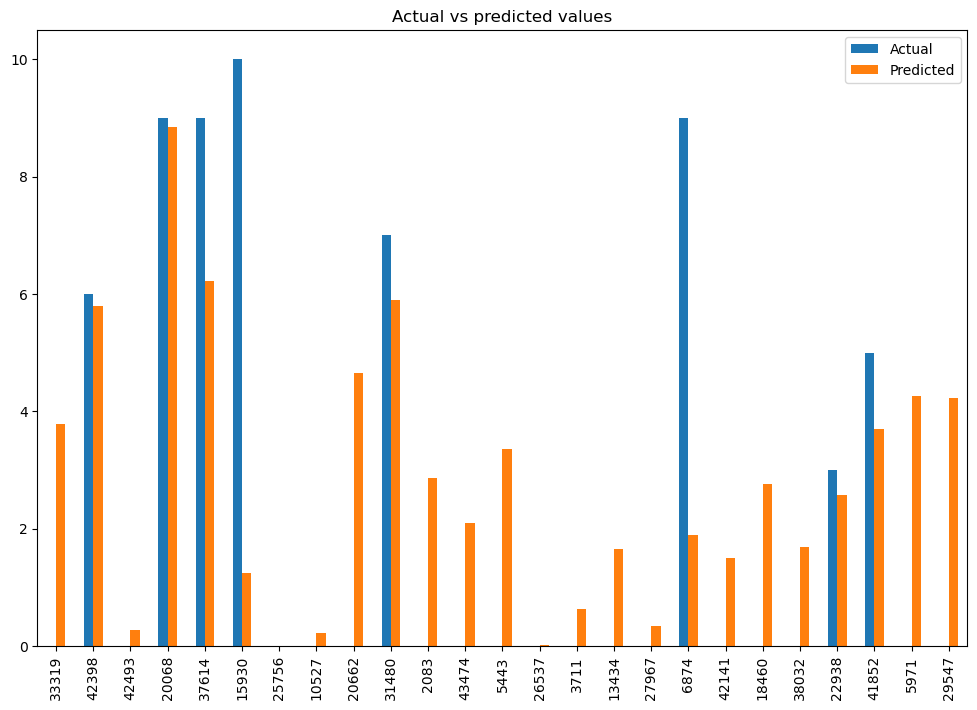

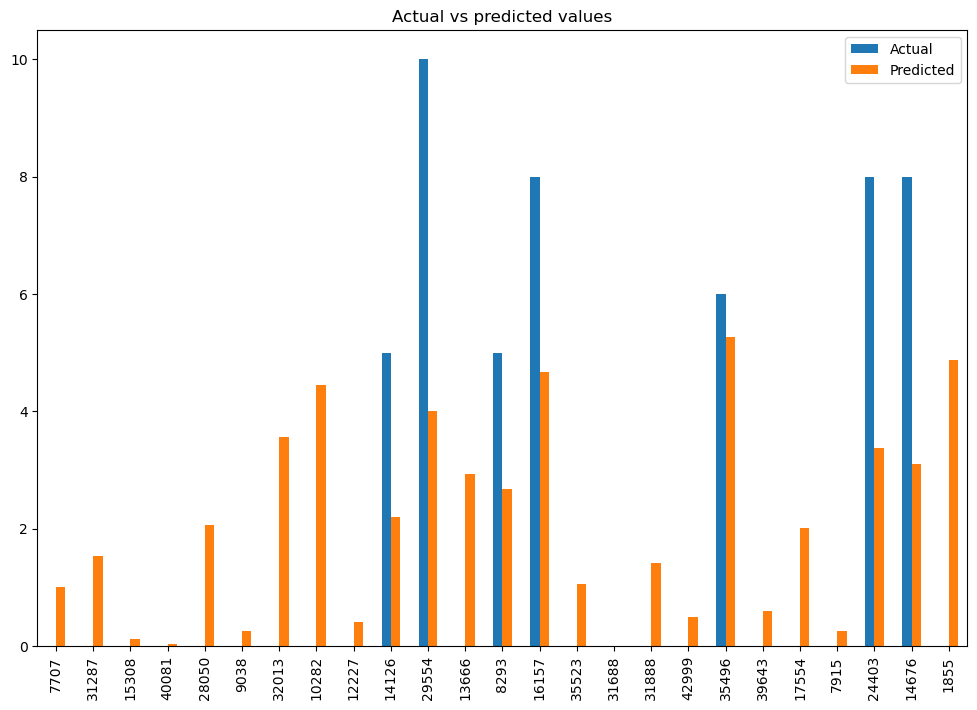

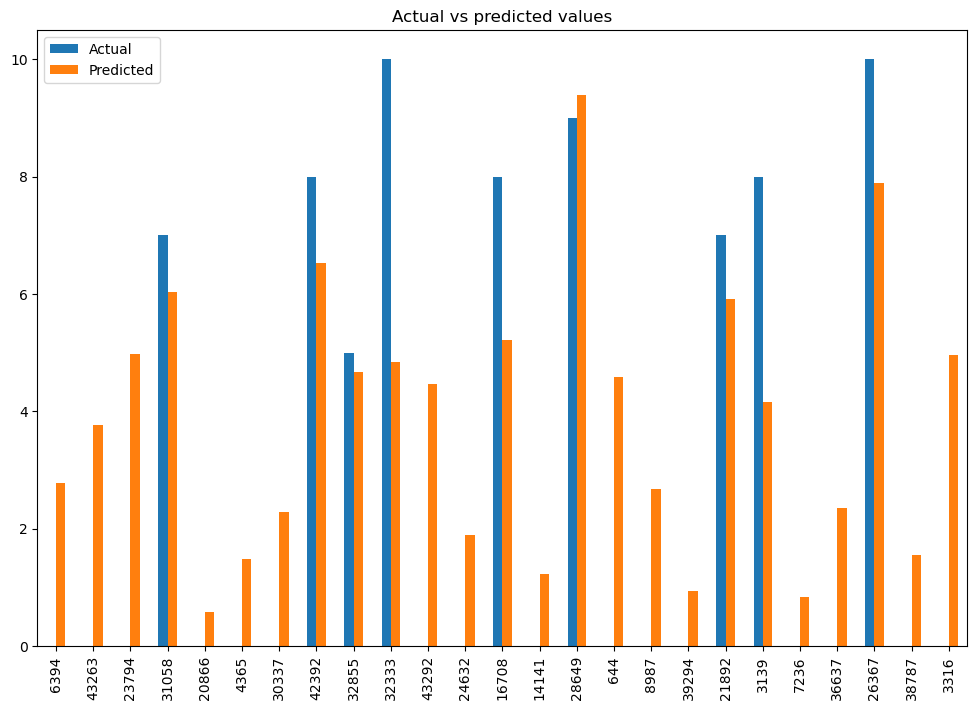

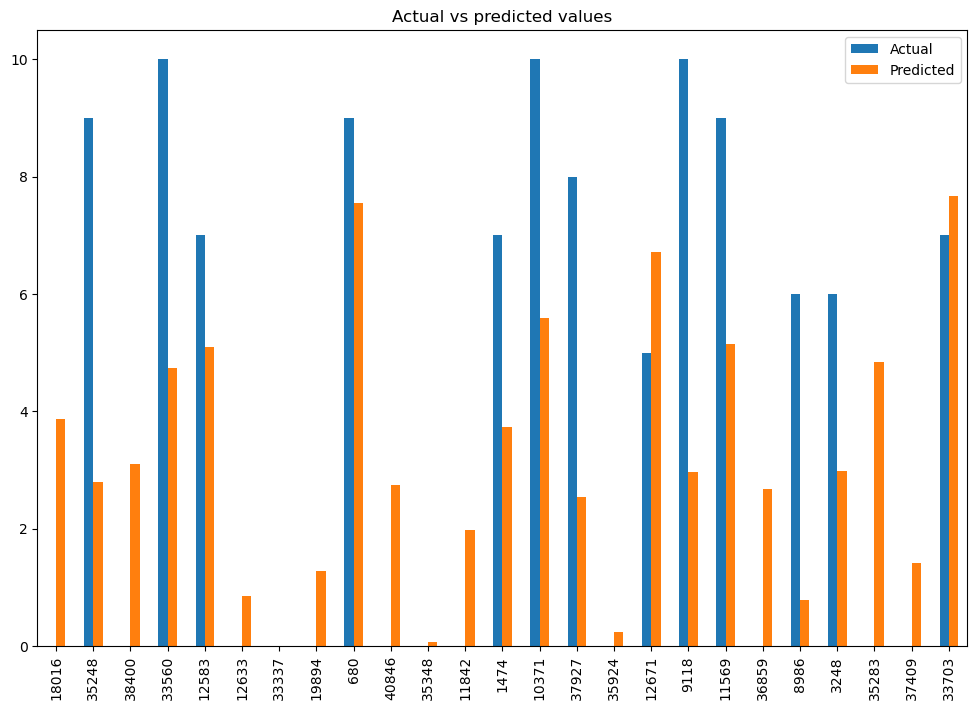

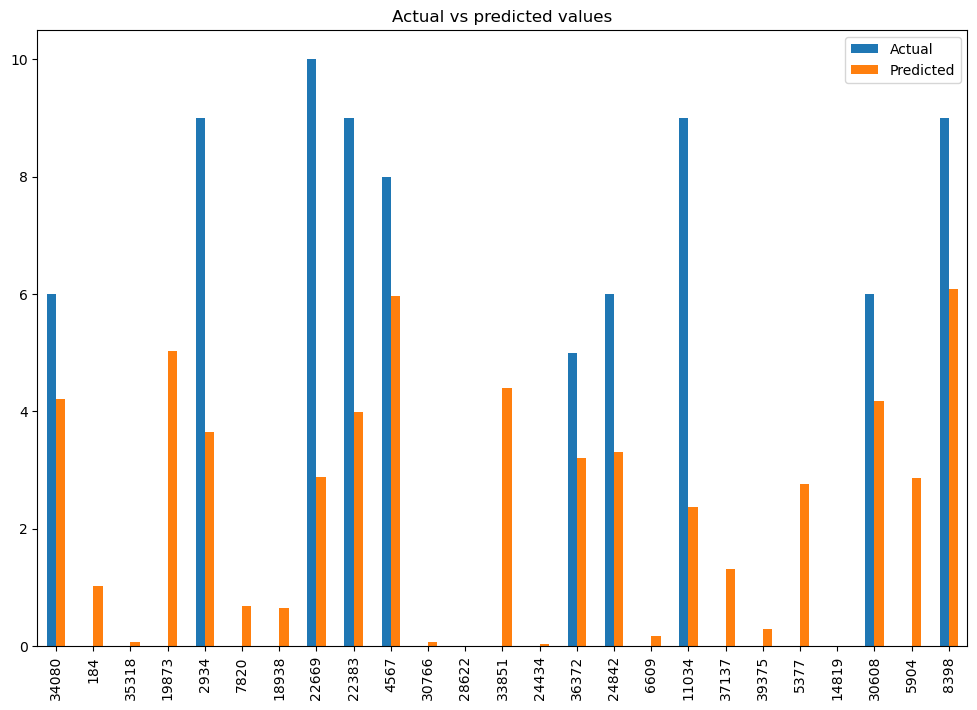

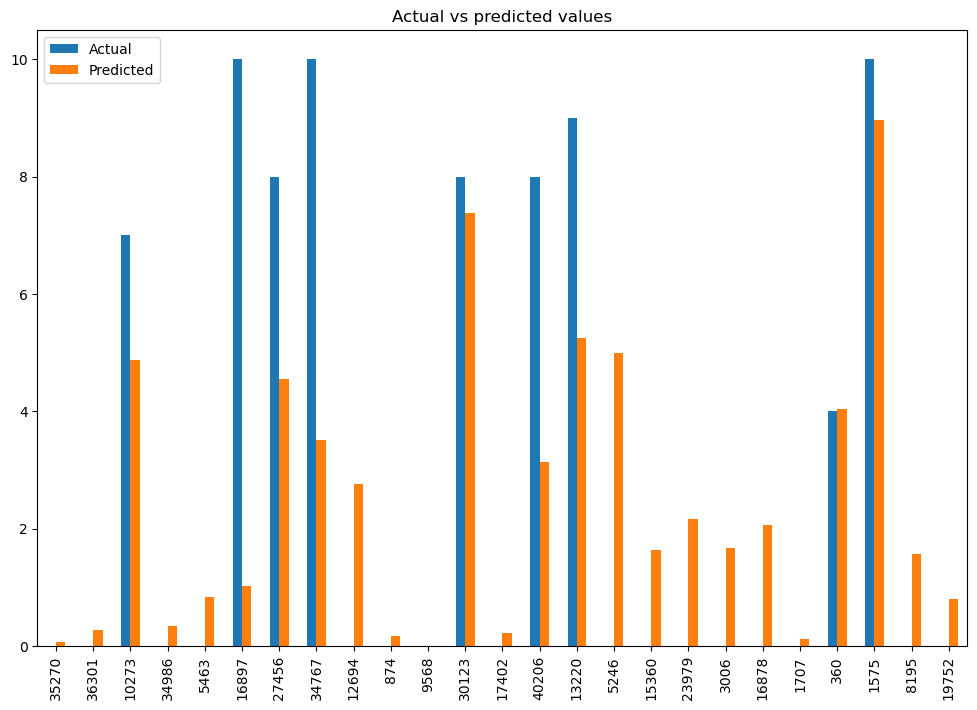

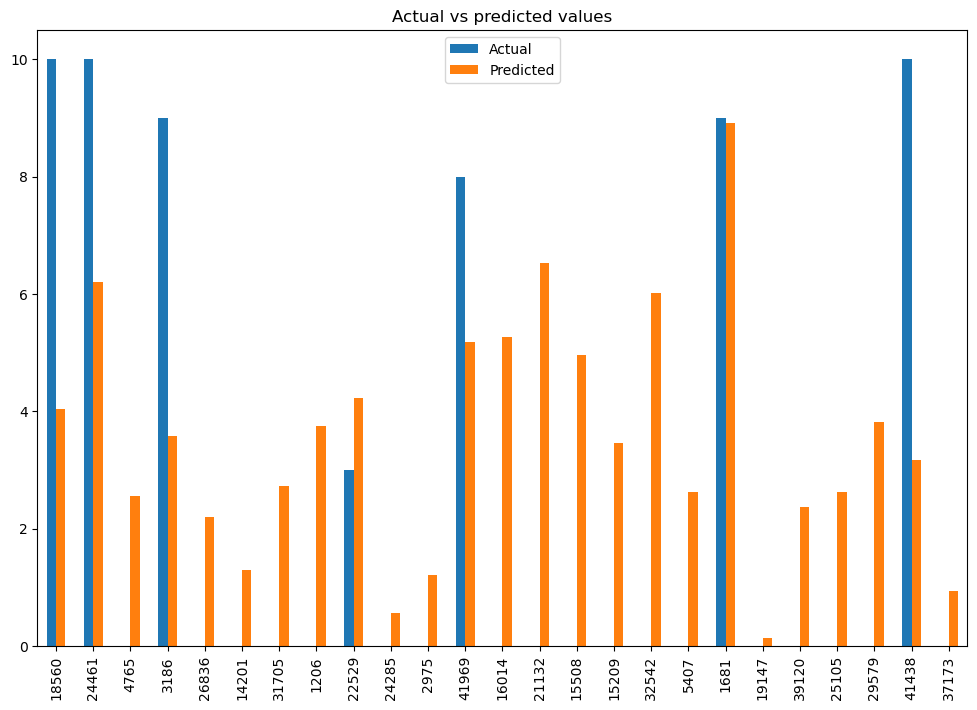

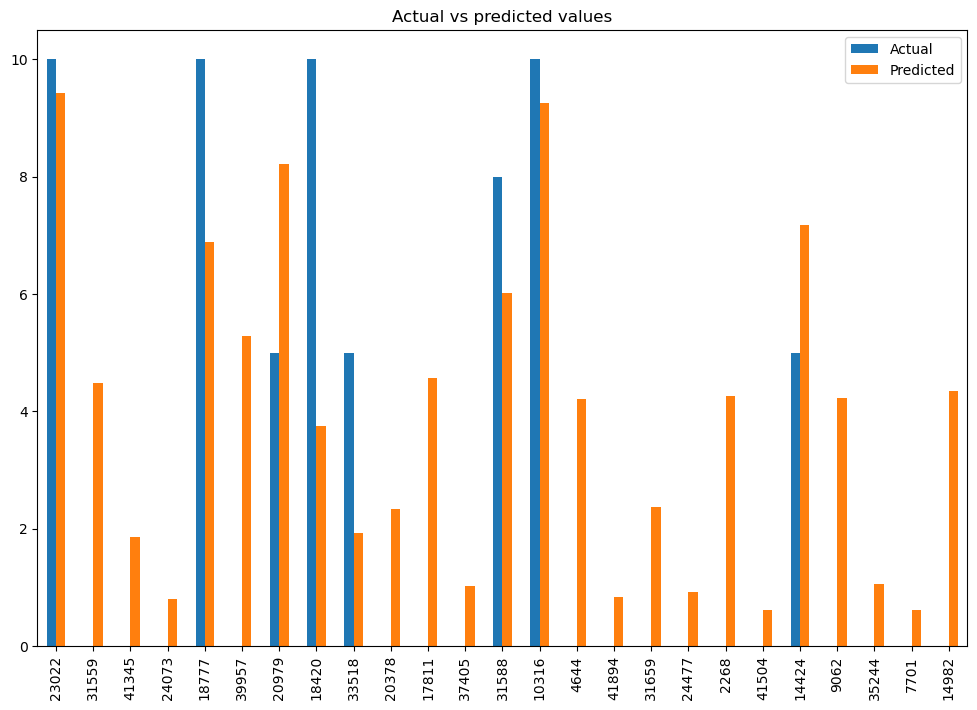

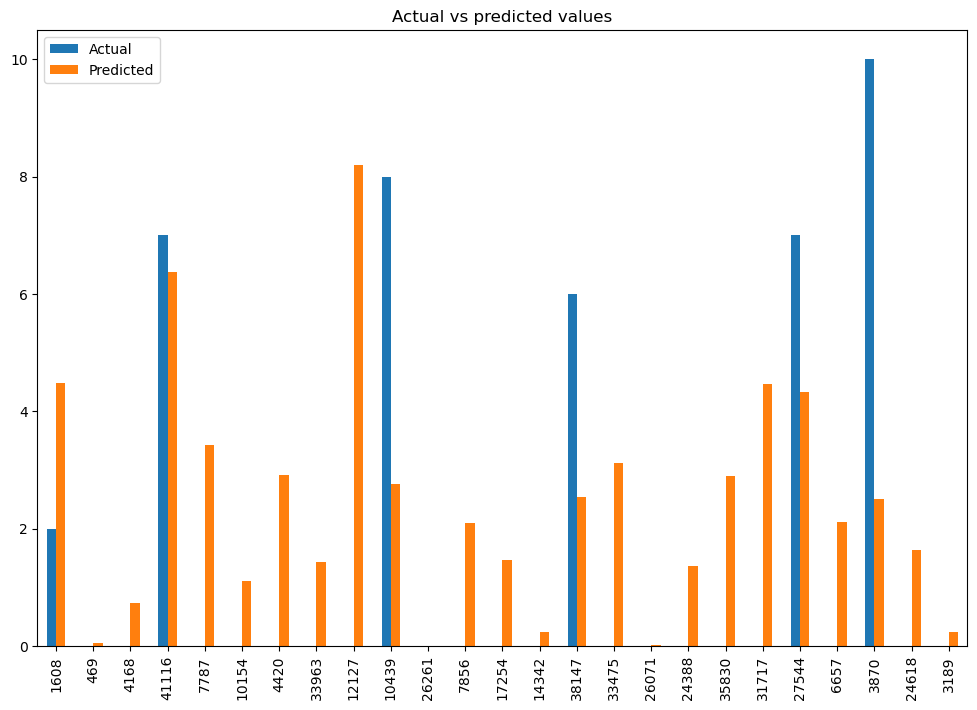

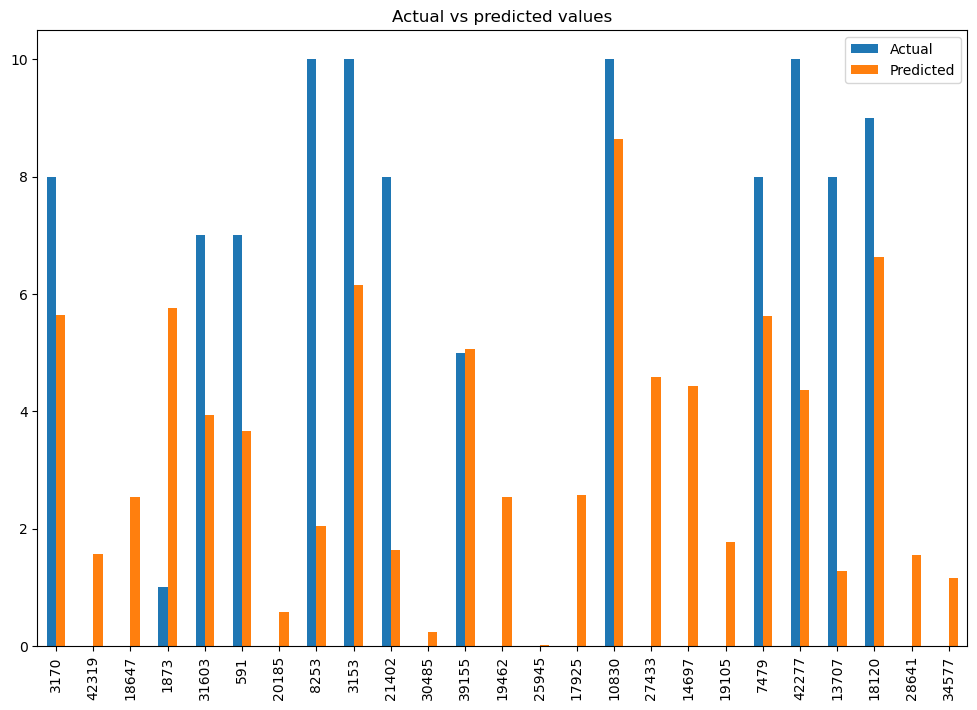

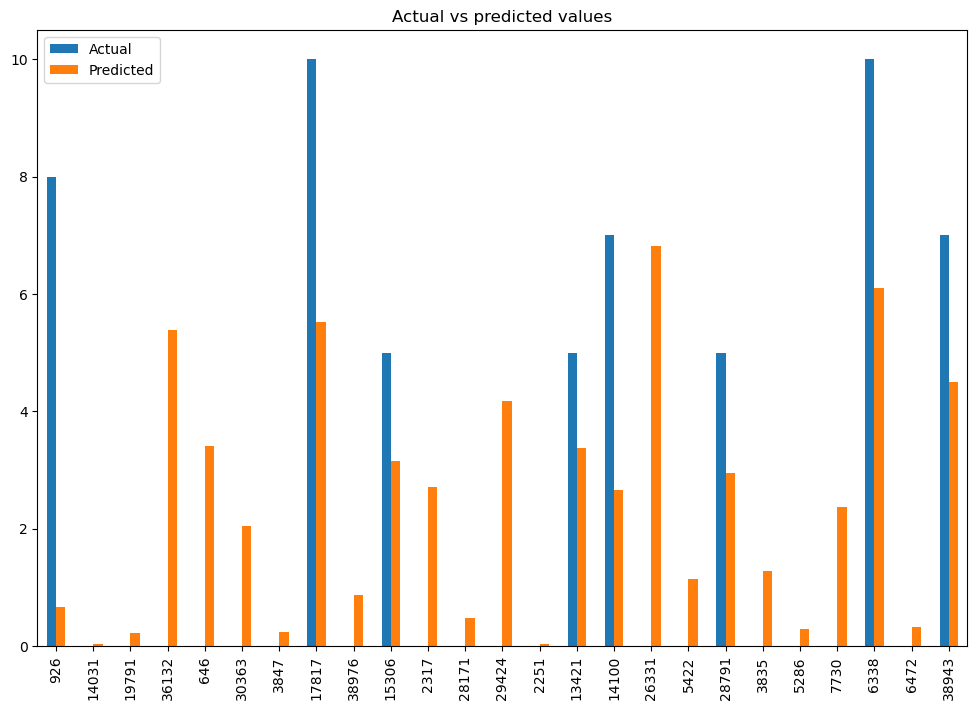

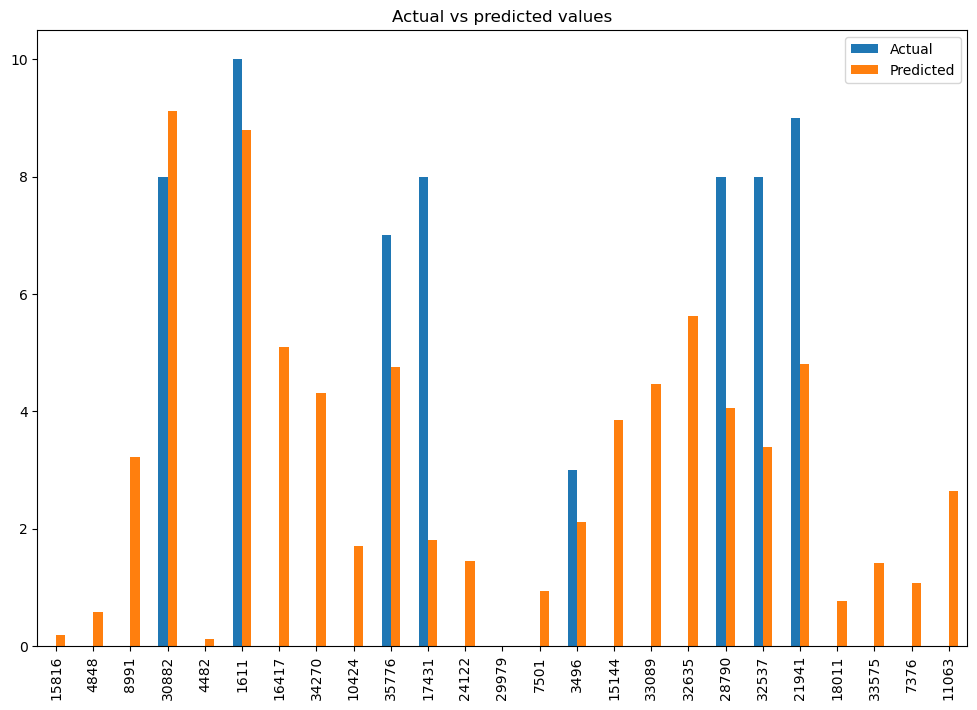

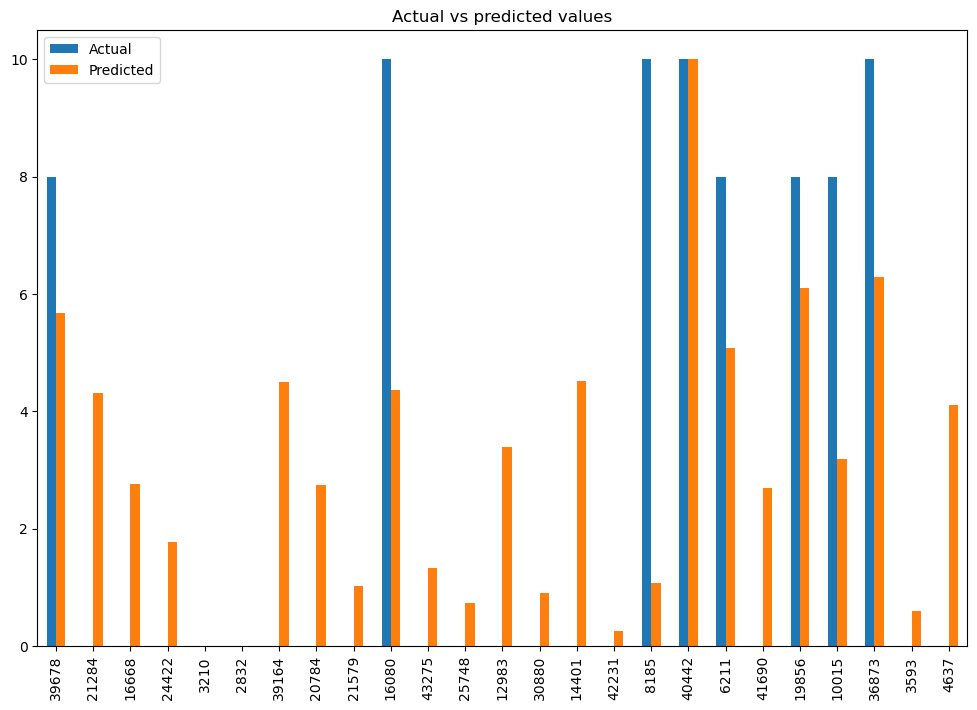

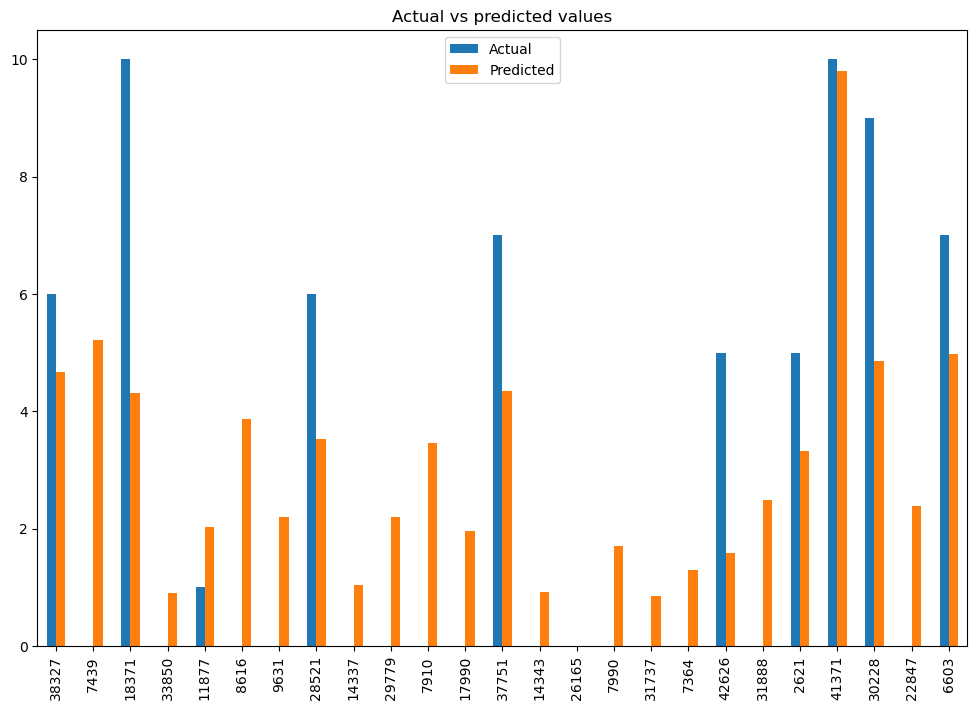

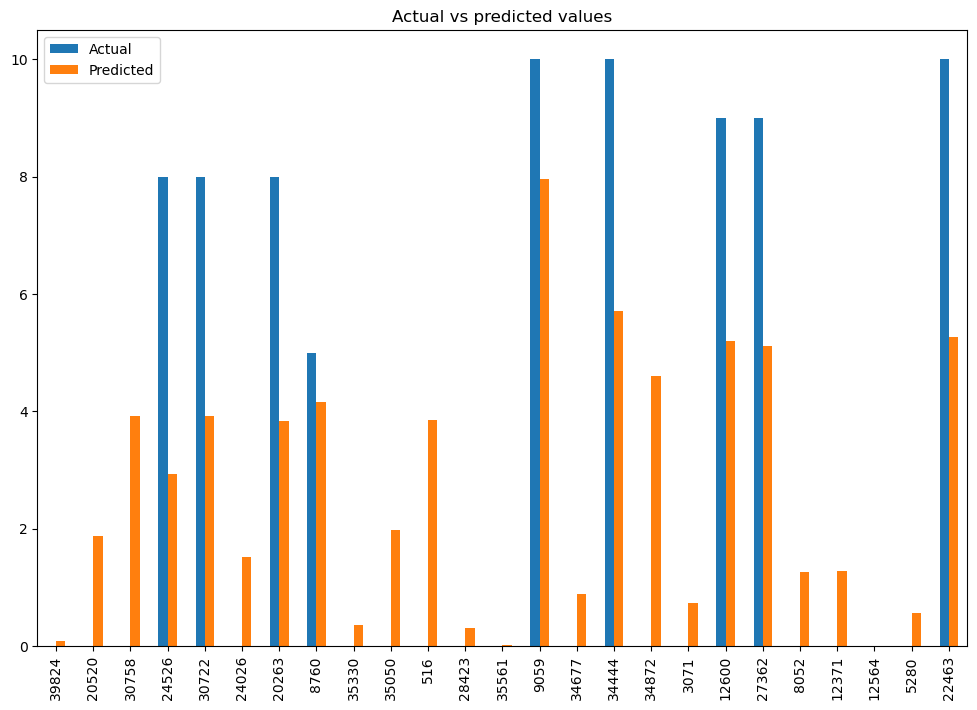

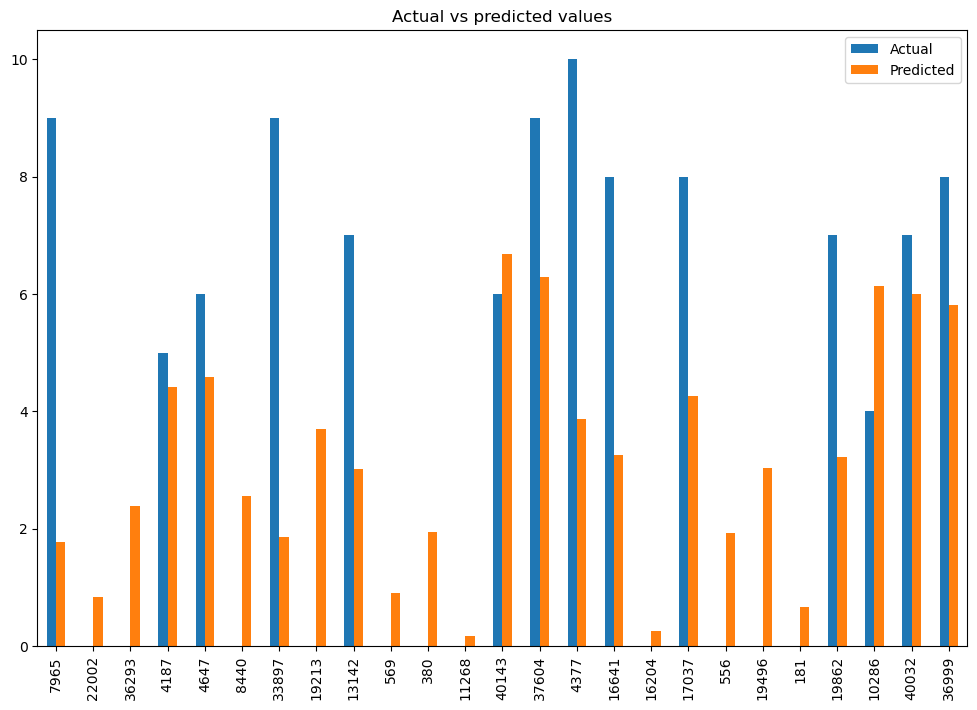

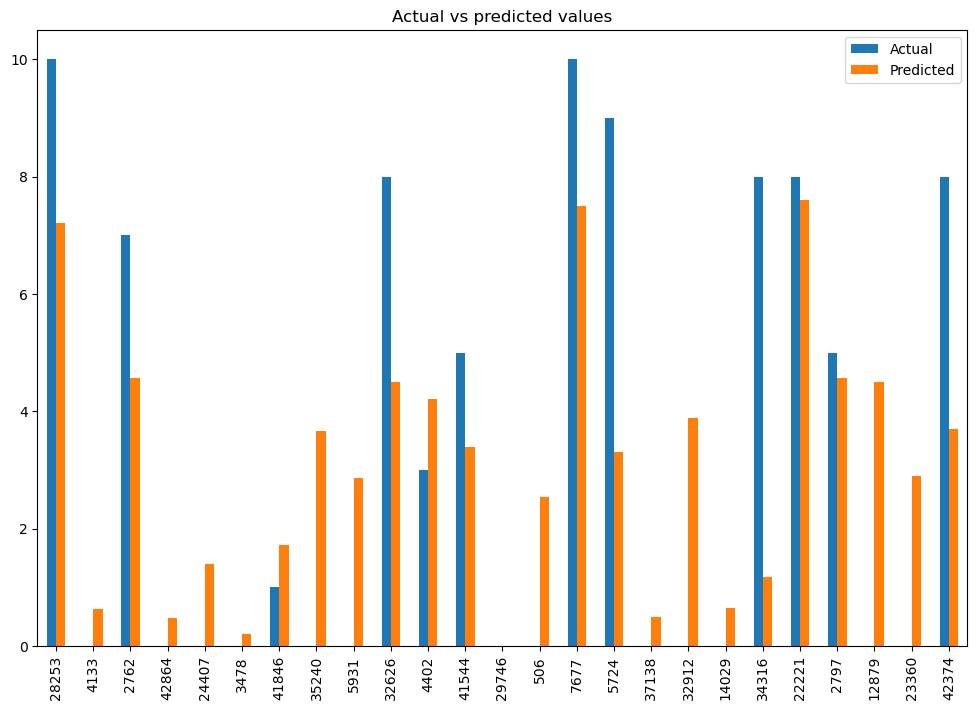

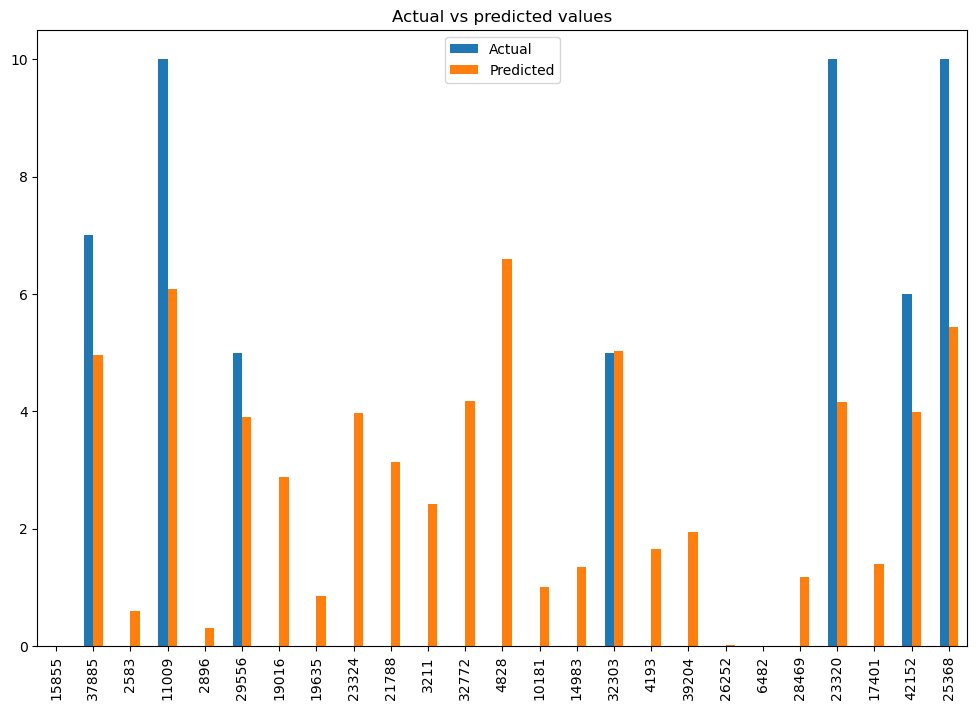

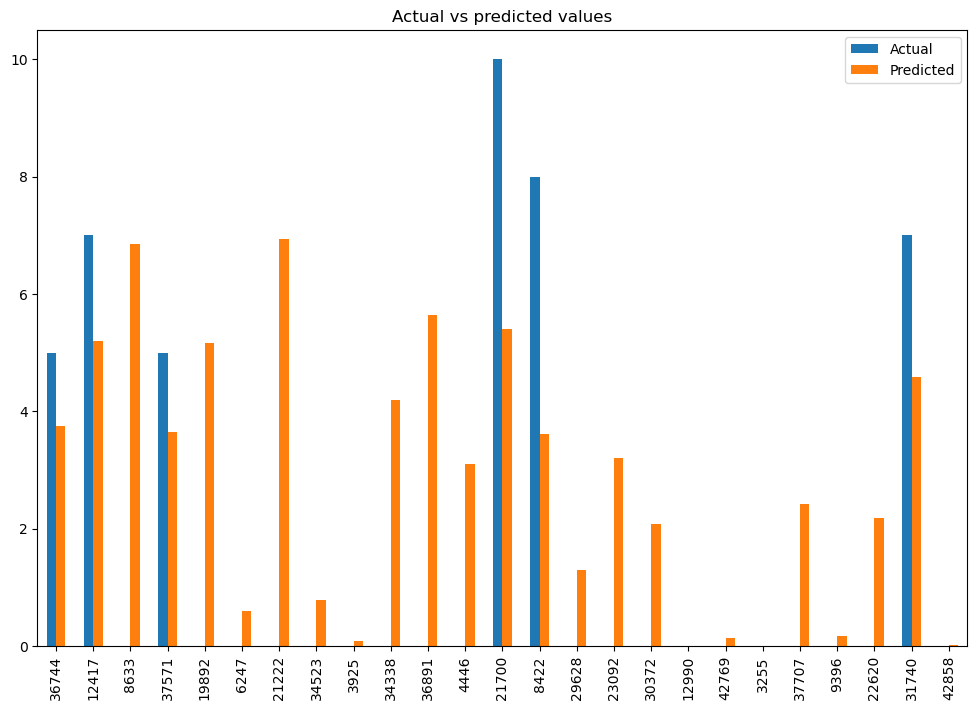

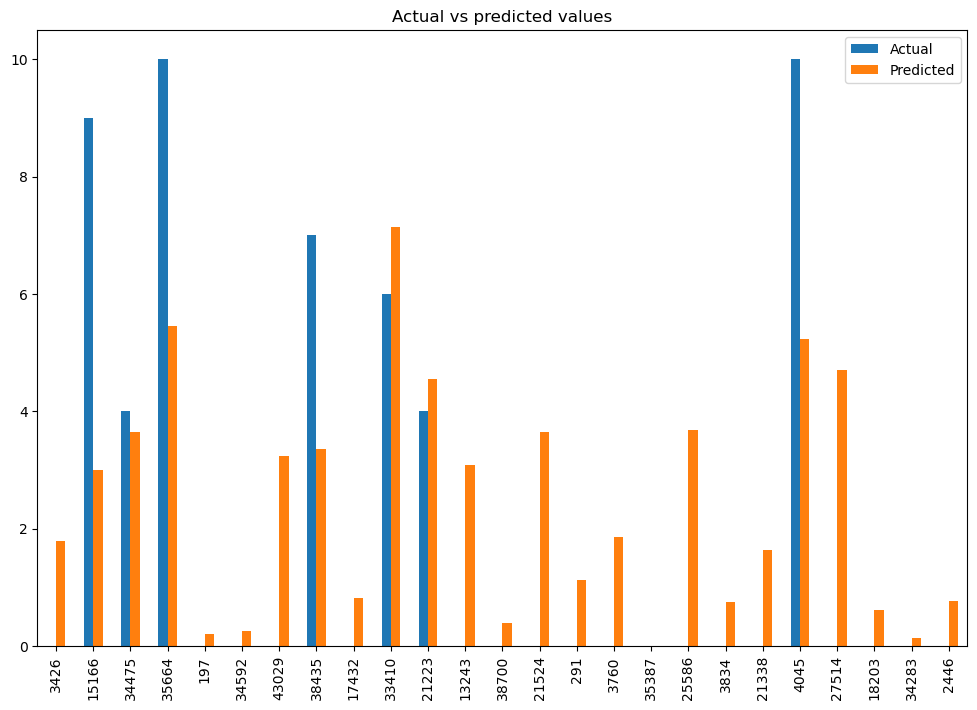

In [62]:
from sklearn.model_selection import KFold, StratifiedKFold
k = 20 # a number of folds best is 20
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Main_Title','Sub_Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Pub_gb']#, 'Language'] ', 

for i, (train_index, test_index) in tqdm(enumerate(skfold.split(X_train, y_train))):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold[FEATURE] = X_train_fold[FEATURE].astype('int')
    X_valid_fold[FEATURE] = X_valid_fold[FEATURE].astype('int')
    
    train_pool = Pool(data=X_train_fold, label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold, label=y_valid_fold, cat_features=FEATURE)

    
    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    x_test[FEATURE] = x_test[FEATURE].astype('int')
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns]),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions


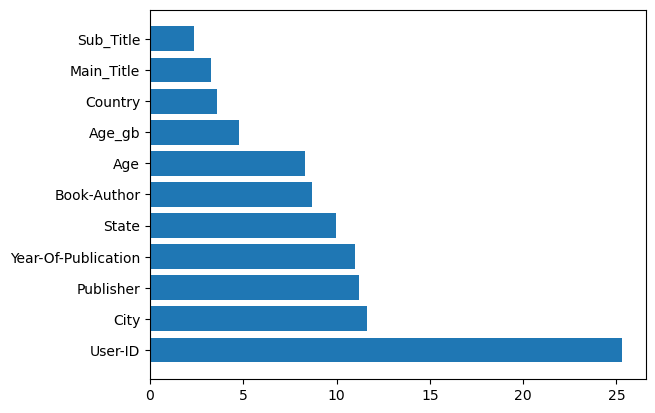

In [63]:
cat_importance_feature = np.argsort(model.feature_importances_)[:-31:-1]
plt.barh(X_train.columns[cat_importance_feature], model.feature_importances_[cat_importance_feature])
plt.show()

In [64]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

,ID,Book-Rating
0,TEST_000000,5.598085
1,TEST_000001,6.434580
2,TEST_000002,6.276827
3,TEST_000003,5.969702
4,TEST_000004,5.679859
...,...,...
159616,TEST_159616,3.677540
159617,TEST_159617,3.332955
159618,TEST_159618,3.738487
159619,TEST_159619,3.683125


<Axes: xlabel='Book-Rating', ylabel='Count'>

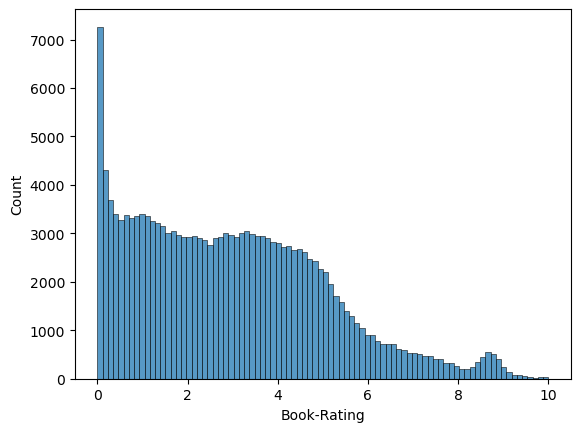

In [65]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [66]:
sub.to_csv('submit_cat+20-folds+split.csv', index=False,encoding="utf-8-sig")